# Gyration plane Tutorial

Welcome to the Gyration plane tutorial! In this tutorial you will learn:
* What is **gyration number** and how it can be computed for any neural activity dataset;
* How **gyration number** can be represented on the **gyration plane**;
* How to compare different real neural datasets on the **gyration plane**.

Let's start with importing our newly developed functions providing interface for rotational analysis of a neural dataset.

In [1]:
from utils.datasets import (GraspingSuresh, 
                            ReachingGallego, 
                            ReachingChurchland, 
                            ReachingKalidindi, 
                            BehaviouralMante, 
                            SyntheticTravelingWave)
from utils.vis import plot_dataset_gyration_plane, peth_normalize
from utils.utils import generate_response, subtract_cc_mean
from utils.color_palettes import blue_yellow_cmap
from jPCA.util import plot_projections, preprocess
import jPCA
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

# Gyration number intuition

Do you remember the concept of covariance matrix? For __centered__ dataset $X \in \mathbf{R}^{t\times n}$ the covariance matrix $C$ reads as $C = X^TX$. In the context of neural recordings this matrix catches the information about the covariance of neurons with each other. We omit great properties of eigendecomposition you can find on the [wiki](https://en.wikipedia.org/wiki/Covariance_matrix). Now we introduce another interesting concept - differential covariance matrix. We define this matrix as $D = \dot{X}^TX$ where $\dot{X} \in \mathbf{R}^{t\times n}$ is the "somehow" computed matrix of first derivative of $X$ (for example by simple `numpy.diff` function). The brilliant property of this matrix is that it is [skew-symmetric](https://en.wikipedia.org/wiki/Skew-symmetric_matrix) when the datasets has intrinsic circular structure (or rotational dynamics). If not, this matrix can be even just symmetric (case of independent decaying of neurons). Another cool property of this matrix is that its structure can be briefly characterized by several eigenvalues (e.g. 2 largest ones). 

It's time to try!

Generating datasets!
Each condition for all neurons


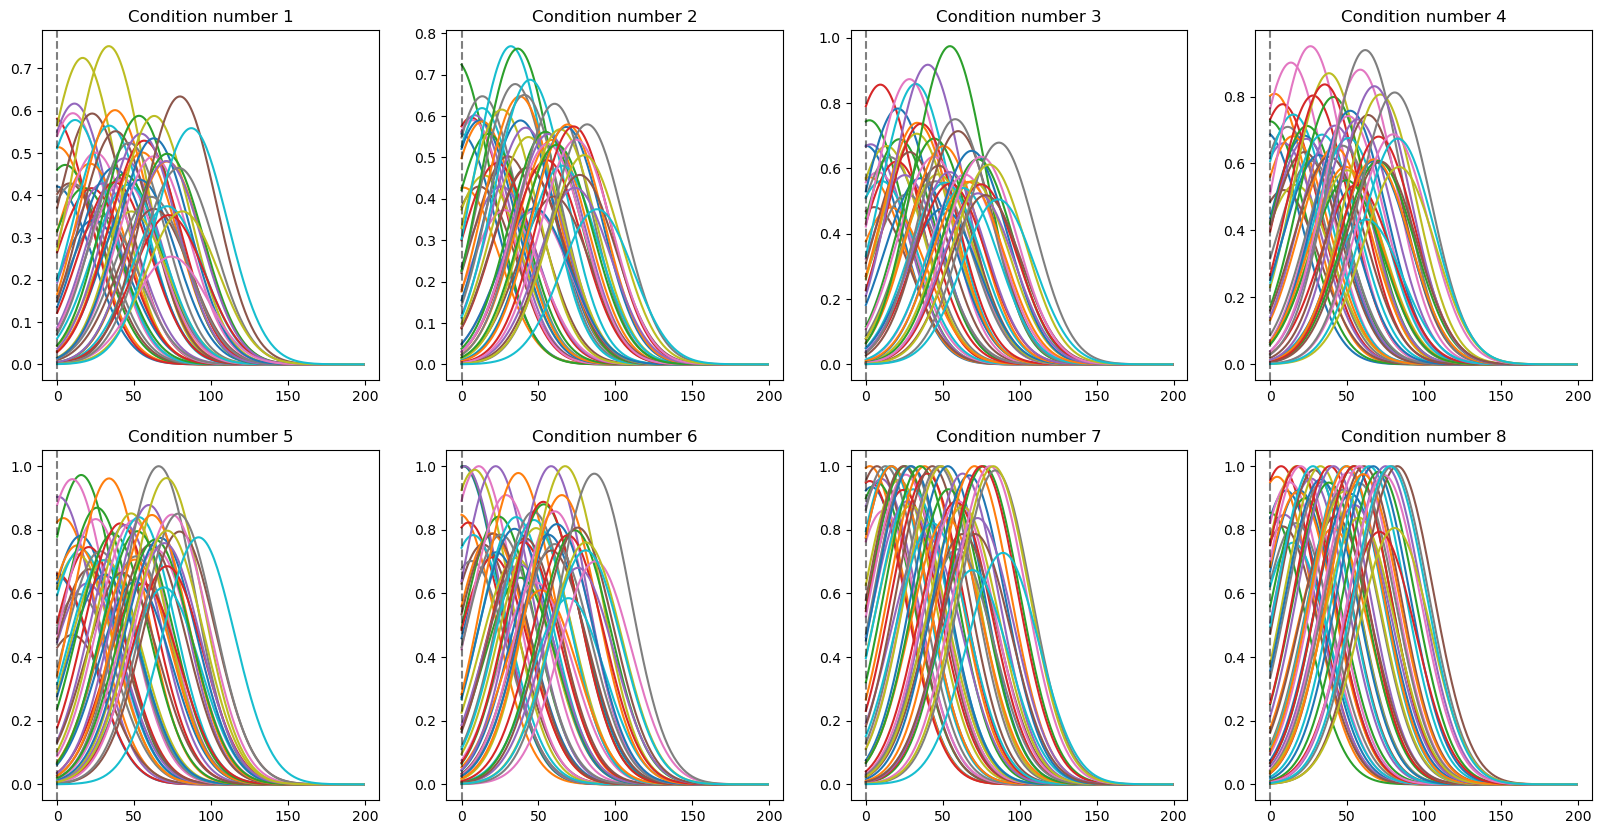

In [2]:
# Let's first create a simple synthetic dataset of 4 conditions and enjoy its rotational dynamics.

# let's initialize a class for dataset
syn = SyntheticTravelingWave('datasets')

# define parameters for synthetic dataset, 
# you shouldn't bother about this parameters now, just trust us :)
p = {'amp_noise':0.1, 
     'phase_noise':10, 
     'sigma_noise':0, 
     'sigma':100, 
     'ncond':8,     # <--- number of conditions
     'a':0, 
     'b':5.1, 
     't_max':600, 
     'N':50,        # <--- number of neurons
     'steps':200
     }
syn.preprocess_data(**p)

#plot all neurons with each of the condition to understand neural dynamics within conditions
syn.plot_conditions(subtract_mean=False)

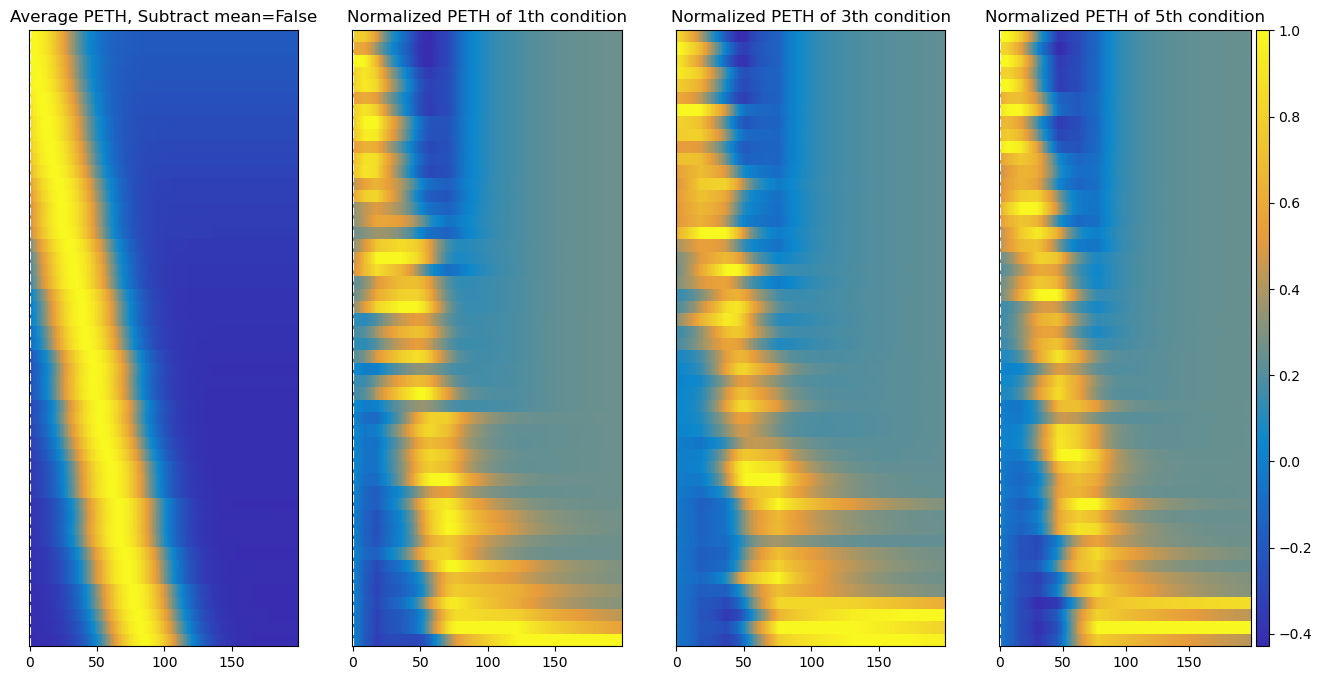

In [3]:
#let's plot PETH (Peri-Event Time Histogram), aka "the top view" on running wave
syn.plot_peth(subtract_mean=False, cond_list=[1, 3, 5])

jPCA


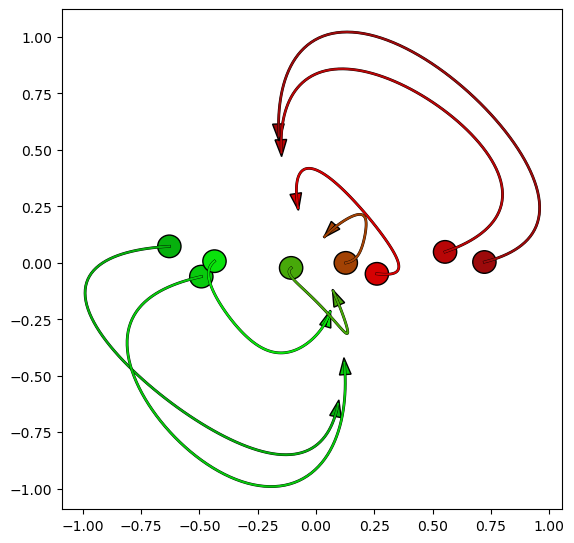

In [4]:
#finally let's plot jPCA
syn.plot_jpca(tstart=0, tend=90)

Do you see the clear rotational dynamics in the synthetic dataset? If yes, can we quantify this "rotationess" somehow? The differential covariance matrix discussed previously is key to this quantification. Let's build this matrix for one condition...

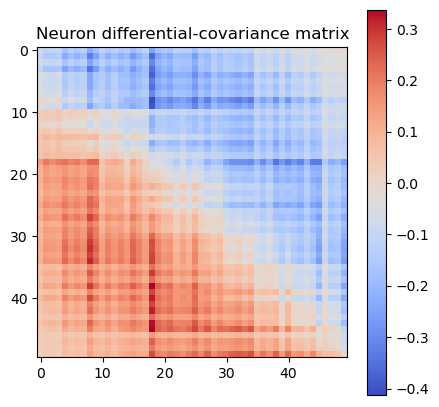

In [5]:
c = syn.data[0]

X = np.concatenate([x[:-1] for x in [c]])
X_dot = np.concatenate([np.diff(x, axis=0) for x in [c]])
dcov_N = X_dot.T @ X

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.title('Neuron differential-covariance matrix', fontsize=12)
plt.imshow(dcov_N, interpolation='none', cmap='coolwarm')
plt.colorbar()
plt.show()

Indeed, this matrix has an approximately skew symmetric structure which corresponds to observed rotational dynamics above. 
Now, let's compute gyration number!

In [6]:
#short way to compute gyration number
from utils.utils import compute_gyration
datas = subtract_cc_mean(syn.data.copy()) #subtract cross-conditional mean
x, y = compute_gyration(datas)
print(f'Decay: {round(x, 3)}, Rotation: {round(y, 3)}')

Decay: 0.074, Rotation: 0.607


In [7]:
#long way to compute gyration number
#step 0: call the data
datas = subtract_cc_mean(syn.data.copy()) #subtract cross-conditional mean

#step 1: concatenate conditions and estimate time derivative dataset \dot{X}
X = np.concatenate([x[:-1] for x in datas])
X_dot = np.concatenate([np.diff(x, axis=0) for x in datas])

#step 2: compute differential covariance matrix
D = X_dot.T @ X

#step 3: compute eigenvalues of the matrix
Xeig = np.linalg.eigvals(D)

#step 4: Normalize sum of first two eigenvalue magnitudes for real and imagine part separately
#Note: we found that first two are enough from our empirical studies of the gyration number.
xnom = np.abs(np.real(Xeig[0])) + np.abs(np.real(Xeig[1]))
ynom = np.abs(np.imag(Xeig[0])) + np.abs(np.imag(Xeig[1]))
x = xnom / (np.abs(Xeig).sum())
y = ynom / (np.abs(Xeig).sum())

print(f'Decay: {round(x, 3)}, Rotation: {round(y, 3)}')

Decay: 0.074, Rotation: 0.607


In [8]:
from utils.shuffling import shuffling_CMPT

datas_shuffled = shuffling_CMPT(datas, threshold=0.95, verbose=1)

Initialize initial permutation.
Total number of possible permutations: 1400
Start targeting permutations.
Percent of indices coincide: 12.2500%
Achieved similarity: 0.7978% for 1400 iterations
Done!


If you made it this far, you're awesome! Now, you understand how to compute gyration number. We will use real and imagine part of gyration number to place a dataset on gyration plane which allows to compare multiple datasets with each other.

Let's save our dataset for plotting it on the gyration plane in the next section.

In [9]:
dirname = 'datasets/gyration/'
syn.save2h5('synth1.h5', dirname)

File synth1.h5 successfully saved!


# Try for real data.

Let's try to build gyration plane for Churchland et al., 2012 dataset comparing its with one we previously synthesized.

In [10]:
#initialize a class for Churchland's dataset
church = ReachingChurchland('datasets/')
#upload the file corresponding to the class structure
church.load_data('churchland2012.mat')
#preprocess data as in the original Churchland paper (this is an in-build class methods defined specifically for the study)
church.preprocess_data()
#crop time points of dataset for better vizualization on Gyration plane
church.crop_data(tstart=5, tend=30)
# select 8 conditions from churchland
church.data = church.data[:8]

#save the prepared data in the folder from which gyration plane function will take datasets
church.save2h5('church.h5', dirname)

File churchland2012.mat successfully loaded!
No preprocessing needed! Loaded.
File church.h5 successfully saved!


We can also try different shufflings of original data proposed in original Churchland et al, 2012, or [Michaels et al, 2016](https://doi.org/10.1371/journal.pcbi.1005175). Let's just import them.

In [30]:
#initialize new classes for shuffled data
# Churchland
church_shuffle_1 = ReachingChurchland('datasets/')
church_shuffle_1.load_data('churchland2012.mat')
church_shuffle_1.preprocess_data()
church_shuffle_1.crop_data(tstart=5, tend=30)
church_shuffle_1.data = church_shuffle_1.data[:8] # select 8 conditions from churchland
# the method performing 3 differrent shufflings from Churchland paper or Michaels paper      
church_shuffle_1.shuffle_data(shuffling_type=1)
church.save2h5('church_shuffle_1.h5', dirname)

# Michaels           
church_shuffle_cmpt = ReachingChurchland('datasets/')
church_shuffle_cmpt.load_data('churchland2012.mat')
church_shuffle_cmpt.preprocess_data()
church_shuffle_cmpt.crop_data(tstart=5, tend=30)
church_shuffle_cmpt.data = church_shuffle_cmpt.data[:8] # select 8 conditions from churchland
# the method performing 3 differrent shufflings from Churchland paper or Michaels paper      
church_shuffle_cmpt.shuffle_data(shuffling_type='cmpt')
church.save2h5('church_shuffle_cmpt.h5', dirname)

File churchland2012.mat successfully loaded!
No preprocessing needed! Loaded.
File church_shuffle_1.h5 successfully saved!
File churchland2012.mat successfully loaded!
No preprocessing needed! Loaded.
Achieved similarity: 0.9146% for 6104 iterations
Done!
File church_shuffle_cmpt.h5 successfully saved!


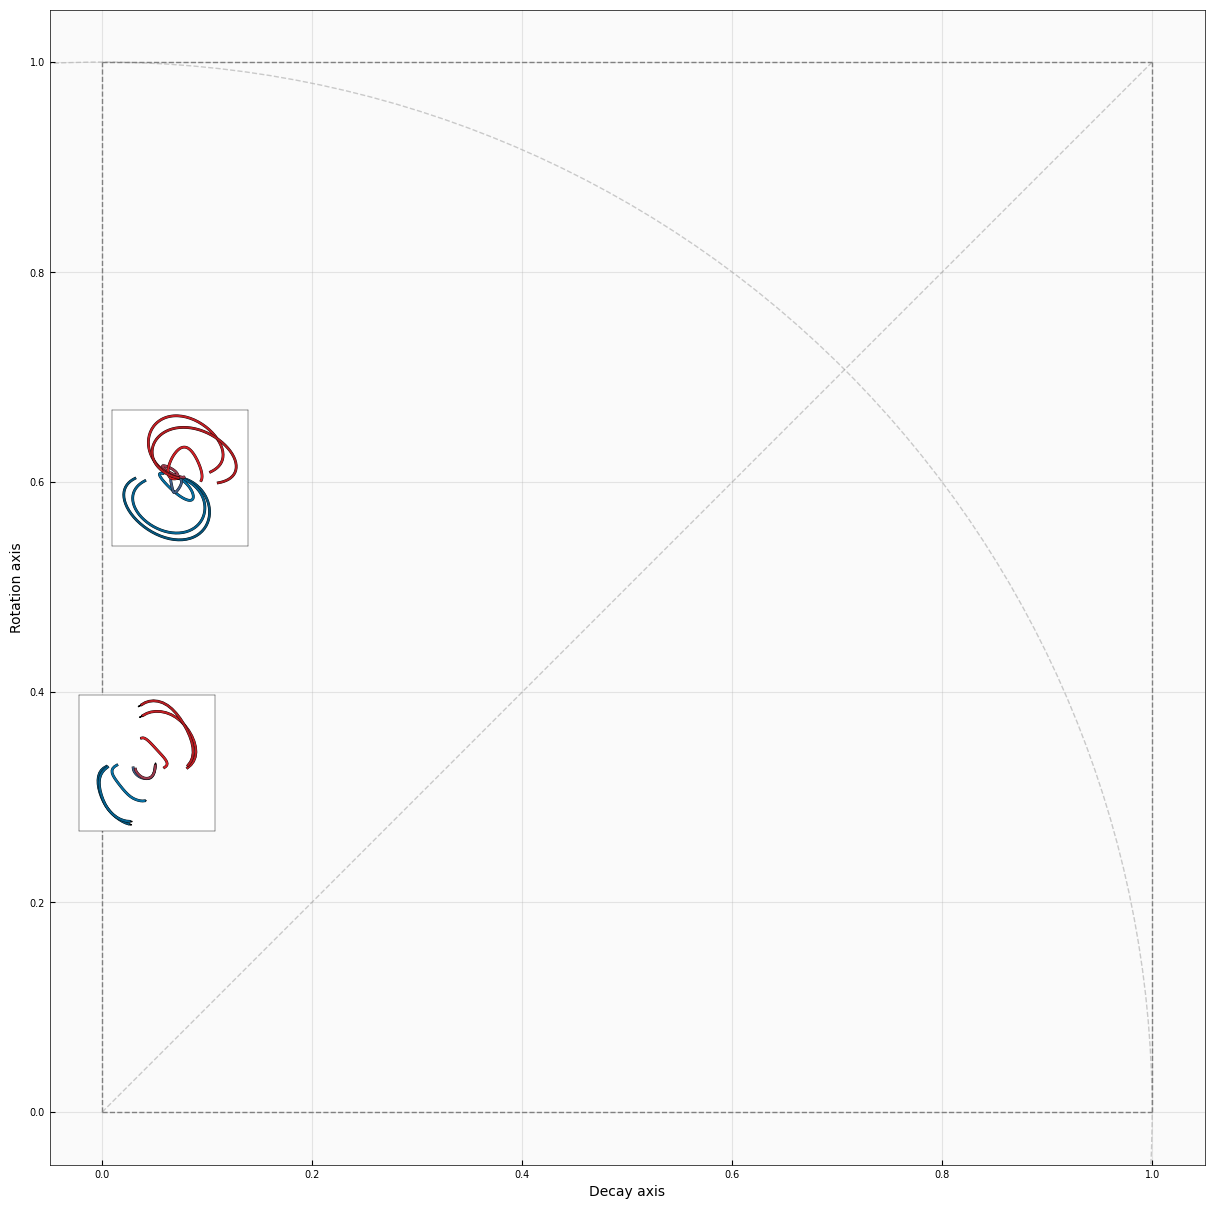

In [32]:
plot_dataset_gyration_plane(cond_n=8, h5_save_dir=dirname, ins_size=0.13)

Wonderful! You may see now how the real dataset of Churchland et al, 2012 is related to the one we just synthesized or shuffled. Obviously, our specially tuned parameters for synthetic neural data yields rotational dynamics. But this dynamics is comparable with that from the real data! The observation that datasets are in upper part of the plane (upper than diagonal) corresponds to their internal rotational sturcture observed in jPCA. Gyration number, therefore, is a **laconic** way to say that a given neural dataset has an internal rotational structure and provides the framework for comparison of different datasets with each other.

# Bonus: Curvature

As we stated in the manuscript, positive curvature of a trajectory is the necessary condition for rotation. Below you may see the estimated curvature for all conditions of Churchland et al, 2012. It is actually positive along the whole of a condition's trajectory.

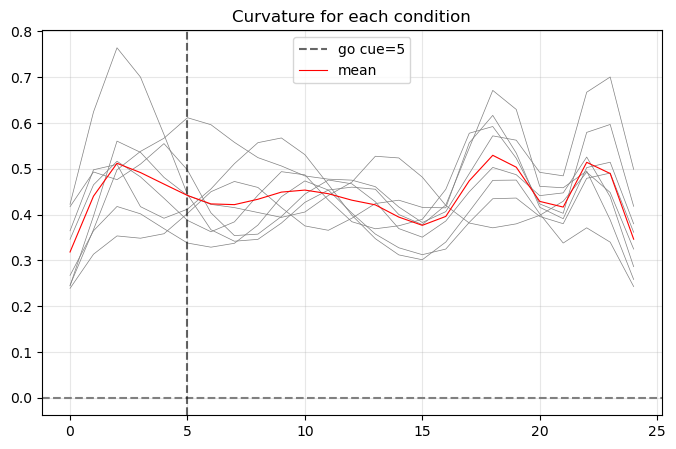

In [13]:
church.plot_curvature()